In [1]:
!splitcode --version
!fasterq-dump --version

splitcode, version 0.30.0

fasterq-dump : 3.0.3 ( 3.0.2 )



In [2]:
import multiprocessing

# Directories where fasta and alignment data will be stored
outdir = "/mnt/data1/10XvParse/Analysis_3/"
wells_folder = "FASTA/wells/"
raw_folder = "FASTA/Raw/"
sra_folder = "SRA/"
tmp_folder = "tmp/"
proc_folder = "FASTA/Processed/"

sample_names = ["H1","H2"]

In [3]:
import os

def make_dir(directory_name, outdir = ""):
    path = outdir+directory_name
    try:
        os.makedirs(path)
        print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [4]:
# Ensure necessary sub-directories exist
for directory_name in [raw_folder, proc_folder, sra_folder, 
                       tmp_folder, wells_folder]:
    make_dir(directory_name, outdir)

Directory 'FASTA/Raw/' already exists.
Directory 'FASTA/Processed/' already exists.
Directory 'SRA/' already exists.
Directory 'tmp/' already exists.
Directory 'FASTA/wells/' created successfully.


In [5]:
file_names = []
srrs = []

# Write SRRs into batch file separated by sample
with open("SRA_accession/parse_accession.txt") as access:
    for line in access:
        line = line.strip()
        if line.startswith('H'):
            i = 0
            name = f"Parse_{line}"
        else:
            i += 1
            filename = f"{name}_{i}"
            file_names.append(filename)
            srrs.append(line)

In [6]:
# Retieve fasta files from SRR numbers
for srr, name in zip(srrs, file_names):
    print(outdir+raw_folder+name)
    !prefetch {srr} --max-size u -O {outdir+sra_folder}
    !fasterq-dump --outdir {outdir+raw_folder} --temp {outdir+tmp_folder} \
        --outfile {name+".fasta"} -f --split-files --skip-technical \
        {outdir+sra_folder+srr+"/"+srr+".sra"} --threads 8 --fasta-unsorted 
    !pigz {outdir+raw_folder+name+"_1.fasta"} -p 8
    !pigz {outdir+raw_folder+name+"_2.fasta"} -p 8

/mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_1

2025-08-28T06:56:25 prefetch.3.0.3: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2025-08-28T06:56:25 prefetch.3.0.3: 1) 'SRR26594152' is found locally
2025-08-28T06:56:25 prefetch.3.0.3: 'SRR26594152' has 0 unresolved dependencies
spots read      : 35,147,434
reads read      : 70,294,868
reads written   : 70,294,868
/mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_2

2025-08-28T07:00:35 prefetch.3.0.3: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2025-08-28T07:00:35 prefetch.3.0.3: 1) 'SRR26594150' is found locally
2025-08-28T07:00:36 prefetch.3.0.3: 'SRR26594150' has 0 unresolved dependencies
spots read      : 36,349,603
reads read      : 72,699,206
reads written   : 72,699,206
/mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H1_3

2025-08-28T07:04:54 prefetch.3.0.3: Current preference is set to retrieve SRA Normalized Format fi

In [6]:
# Generate batch file for each sample
for name in sample_names:
    batch_file = f"batch/parse_batch_{name}.txt"
    with open(batch_file, "w") as batch:
        for file in file_names:
            if name in file:
                fastq_files = [outdir + raw_folder + file + "_1.fasta.gz", 
                        outdir + raw_folder + file + "_2.fasta.gz"]
                batch.write(f"{file}\t{fastq_files[0]}\t{fastq_files[1]}\n")

In [8]:
# Combine fasta files into sample fasta files
def remultiplex(name):
    batch_file = f"batch/parse_batch_{name}.txt"
    mapping = f"run_info/parse_{name}_mapping.txt"
    outb = f"run_info/parse_{name}_barcodes.fastq.gz"
    proc_files = [outdir + proc_folder + f"parse_{name}_1.fasta.gz",
                  outdir + proc_folder + f"parse_{name}_2.fasta.gz"]
    !splitcode --remultiplex \
        --nFastqs=2 --gzip -o {proc_files[0]},{proc_files[1]} \
        --out-fasta --outb={outb} --mapping={mapping} {batch_file} -t 8

with multiprocessing.Pool(processes=2) as pool:
    pool.map(remultiplex,sample_names)
    print("done")

* Using a list of 0 tags (vector size: 0; map size: 0; num elements in map: 0)
* Using a list of 0 tags (vector size: 0; map size: 0; num elements in map: 0)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H2_1_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H2_1_2.fasta.gz
* will process sample 2: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H2_2_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H2_2_2.fasta.gz
* will process sample 3: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H2_3_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H2_3_2.fasta.gz
* will process sample 4: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H2_4_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H2_4_2.fasta.gz
* will process sample 5: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/Parse_H2_5_1.fasta.gz
                         /mnt/data1/10XvP

In [7]:
# Generate fasta file to combine samples into one large dataset
batch_file = f"batch/parse_batch.txt"
with open(batch_file, "w") as batch:
    for name in sample_names:
        file = f"parse_{name}"
        fastq_files = [outdir + proc_folder + file + "_1.fasta.gz", 
                outdir + proc_folder + file + "_2.fasta.gz"]
        batch.write(f"{name}\t{fastq_files[0]}\t{fastq_files[1]}\n")

In [10]:
# Combine samples into one large parse file
mapping = f"run_info/parse_mapping.txt"
outb = f"run_info/parse_barcodes.fastq.gz"
proc_files = [outdir + raw_folder + f"parse_1.fasta.gz",
                outdir + raw_folder + f"parse_2.fasta.gz"]
!splitcode --remultiplex \
    --nFastqs=2 --gzip -o {proc_files[0]},{proc_files[1]} \
    --out-fasta --outb={outb} --mapping={mapping} {batch_file} -t 8

* Using a list of 0 tags (vector size: 0; map size: 0; num elements in map: 0)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H1_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H1_2.fasta.gz
* will process sample 2: /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H2_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H2_2.fasta.gz
583M reads processed         
done 
* processed 589,276,481 reads


In [8]:
# Generate config file to separate reads by well
distances = 1
locations = "1:78:86"
with open("parse_extraction/config_RT.txt", "w") as config:
    config.write("tags\tsubs\tdistances\tlocations\n")
    with open("parse_extraction/r1_R.txt") as randO:
        with open("parse_extraction/r1_T.txt") as polyT:
            for lineO, lineT in zip(randO,polyT):
                lineO = lineO.strip()
                lineT = lineT.strip()
                config.write(f"{lineO}\t{lineT}\t{distances}\t{locations}\n")

In [9]:
# Divide the reads into different wells
with open("parse_extraction/keep_wells.txt", "w") as keep, open("parse_extraction/config_wells.txt", "w") as config:
    n = 0
    with open("parse_extraction/r1_R.txt", "r") as R:
        keep.truncate()
        config.truncate()
        config.write("tags\tlocations\tdistances\n")

        for line in R:
            n += 1
            keep.write(line.strip() + "\t" + outdir + f"{wells_folder}randO_well_" + str(n) + "\n")
            config.write(line.strip() + "\t" + "1:78:86" + "\t\t" + "1" + "\n")

    n = 0
    with open("parse_extraction/r1_T.txt", "r") as T:
        for line in T:
            n += 1
            keep.write(line.strip() + "\t" + outdir +  f"{wells_folder}polyT_well_" + str(n) + "\n")
            config.write(line.strip() + "\t" + "1:78:86" + "\t\t" + "1" + "\n")

In [10]:
# Extract by well
proc_files = [outdir + raw_folder + f"parse_1.fasta.gz",
                outdir + raw_folder + f"parse_2.fasta.gz"]
!splitcode -c parse_extraction/config_wells.txt --gzip --keep-r1-r2 \
    --keep=parse_extraction/keep_wells.txt --nFastqs=2 --no-output \
    --out-fasta --no-outb {proc_files[0]} {proc_files[1]} -t 8

* Using a list of 192 tags (vector size: 192; map size: 5,885; num elements in map: 6,336)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Raw/parse_2.fasta.gz
583M reads processed         
done 
* processed 589,276,481 reads


In [11]:
# Extract polyT reads
def extractPolyT(name):
    polyT_files = [outdir+proc_folder+f"polyT_{name}_1.fasta.gz",
                   outdir+proc_folder+f"polyT_{name}_2.fasta.gz"]
    proc_files = [outdir + proc_folder + f"parse_{name}_1.fasta.gz",
                  outdir + proc_folder + f"parse_{name}_2.fasta.gz"]
    
    !splitcode -c parse_extraction/config_RT_polyT.txt --nFastqs=2 --gzip \
        --assign --out-fasta -o {polyT_files[0]},{polyT_files[1]} \
        --outb=run_info/polyT_barcodes.fastq.gz --mapping=run_info/polyT_mapping.txt\
        --summary=run_info/polyT_summary.txt \
        {proc_files[0]} {proc_files[1]} -t 8

with multiprocessing.Pool(processes=2) as pool:
    pool.map(extractPolyT,sample_names)
    print("done")

* Using a list of 96 tags (vector size: 96; map size: 3,027; num elements in map: 3,168)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H2_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H2_2.fasta.gz
* processing the reads ...* Using a list of 96 tags (vector size: 96; map size: 3,027; num elements in map: 3,168)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H1_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H1_2.fasta.gz
264M reads processed (51.5% assigned)
done 
* processed 287,286,561 reads, 135,121,385 reads were assigned
295M reads processed (51.5% assigned)
done 
* processed 301,989,920 reads, 155,543,058 reads were assigned
done


In [12]:
# Extract randO reads
def extractRandO(name):
    randO_files = [outdir+proc_folder+f"randO_{name}_1.fasta.gz",
                   outdir+proc_folder+f"randO_{name}_2.fasta.gz"]
    proc_files = [outdir + proc_folder + f"parse_{name}_1.fasta.gz",
                  outdir + proc_folder + f"parse_{name}_2.fasta.gz"]
    
    !splitcode -c parse_extraction/config_RT_randO.txt --nFastqs=2 --gzip \
        --assign -o {randO_files[0]},{randO_files[1]} --outb=run_info/randO_barcodes.fastq.gz \
        --mapping=run_info/randO_mapping.txt --summary=run_info/randO_summary.txt \
        --out-fasta {proc_files[0]} {proc_files[1]} -t 8

with multiprocessing.Pool(processes=2) as pool:
    pool.map(extractRandO,sample_names)
    print("done")

* Using a list of 96 tags (vector size: 96; map size: 2,989; num elements in map: 3,168)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H1_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H1_2.fasta.gz
* processing the reads ...* Using a list of 96 tags (vector size: 96; map size: 2,989; num elements in map: 3,168)
* will process sample 1: /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H2_1.fasta.gz
                         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H2_2.fasta.gz
263M reads processed (34.2% assigned)
done 
* processed 301,989,920 reads, 89,200,166 reads were assigned
279M reads processed (34.2% assigned)
done 
* processed 287,286,561 reads, 98,423,218 reads were assigned
done


In [13]:
# Download human genome
!kb ref --overwrite -d human -i index.idx -g t2g.txt

[2025-08-28 15:34:35,250]    INFO [download] Downloading files for human (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/human_index_standard.tar.xz to tmp/human_index_standard.tar.xz
100%|████████████████████████████████████████| 138M/138M [00:03<00:00, 47.7MB/s]
[2025-08-28 15:34:38,293]    INFO [download] Extracting files from tmp/human_index_standard.tar.xz


In [14]:
# Prepare batch file to pseudalign reads by well
rando_well = outdir + "FASTA/wells/randO_well_"
polyt_well = outdir + "FASTA/wells/polyT_well_"
with open("parse_extraction/batch_wells.txt", "w") as batch:
    batch.truncate()
    for n in range(1,97):
        batch.write("RandO_Well" + str(n) + "\t" + rando_well + str(n) + "_R1.fasta.gz\t" + rando_well + str(n) + "_R2.fasta.gz\n")
    for n in range(1,97):
        batch.write("PolyT_Well" + str(n) + "\t" + polyt_well + str(n) + "_R1.fasta.gz\t" + polyt_well + str(n) + "_R2.fasta.gz\n")

In [15]:
# Aligne all parse reads
def alignParse(name):  
    parse_out = outdir + f"parse_{name}_out"
    proc_files = [outdir + proc_folder + f"parse_{name}_1.fasta.gz",
                  outdir + proc_folder + f"parse_{name}_2.fasta.gz"]
    # Pseudoalign all parse reads
    !kb count --overwrite --h5ad -r parse_extraction/replace.txt -i index.idx -g t2g.txt -x SPLIT-SEQ -o {parse_out} {proc_files[0]} {proc_files[1]}
with multiprocessing.Pool(processes=2) as pool:
    pool.map(alignParse,sample_names)
    print("done")

[2025-08-28 15:35:00,935]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/parse_H1_out from
[2025-08-28 15:35:00,935]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H1_1.fasta.gz
[2025-08-28 15:35:00,935]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H1_2.fasta.gz
[2025-08-28 15:35:00,961]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/parse_H2_out from
[2025-08-28 15:35:00,961]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H2_1.fasta.gz
[2025-08-28 15:35:00,961]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/parse_H2_2.fasta.gz
[2025-08-28 16:04:07,808]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/parse_H2_out/output.bus to /mnt/data1/10XvParse/Analysis_3/parse_H2_out/tmp/output.s.bus
[2025-08-28 16:04:25,636]    INFO [count] On-list not provided
[2025-08-

In [16]:
wells_out = outdir + "wells_out"
# Pseudoalign parse reads by well
!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x SPLIT-SEQ -o {wells_out} --batch-barcodes parse_extraction/batch_wells.txt

[2025-08-28 16:07:28,567]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/wells_out from
[2025-08-28 16:07:28,567]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/wells_out/tmp/tmphnxpkv_8
[2025-08-28 16:52:01,374]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/wells_out/output.bus to /mnt/data1/10XvParse/Analysis_3/wells_out/tmp/output.s.bus
[2025-08-28 16:52:26,411]    INFO [count] On-list not provided
[2025-08-28 16:52:26,411]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to /mnt/data1/10XvParse/Analysis_3/wells_out
[2025-08-28 16:52:26,411]    INFO [count] Inspecting BUS file /mnt/data1/10XvParse/Analysis_3/wells_out/tmp/output.s.bus
[2025-08-28 16:52:31,819]    INFO [count] Correcting BUS records in /mnt/data1/10XvParse/Analysis_3/wells_out/tmp/output.s.bus to /mnt/data1/10XvParse/Analysis_3/wells_out/tmp/output.s.c.bus with on-list /mnt/data1/10XvParse/Analysis_3/wells_out/splitseq_version2_whitelist

In [17]:
# Pseudoalign PolyT reads
def alignPolyT(name):   
    polyT_out = outdir + f"polyT_{name}_out"
    polyT_files = [outdir + proc_folder + f"polyT_{name}_1.fasta.gz",
                  outdir + proc_folder + f"polyT_{name}_2.fasta.gz"]
    !kb count --overwrite --h5ad -i index.idx -g t2g.txt -x SPLIT-SEQ -o {polyT_out} {polyT_files[0]} {polyT_files[1]} 

with multiprocessing.Pool(processes=2) as pool:
    pool.map(alignPolyT,sample_names)
    print("done")

[2025-08-28 16:53:42,909]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/polyT_H2_out from
[2025-08-28 16:53:42,909]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/polyT_H2_1.fasta.gz
[2025-08-28 16:53:42,910]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/polyT_H2_2.fasta.gz
[2025-08-28 16:53:42,932]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/polyT_H1_out from
[2025-08-28 16:53:42,932]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/polyT_H1_1.fasta.gz
[2025-08-28 16:53:42,932]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/polyT_H1_2.fasta.gz
[2025-08-28 17:06:32,431]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/polyT_H2_out/output.bus to /mnt/data1/10XvParse/Analysis_3/polyT_H2_out/tmp/output.s.bus
[2025-08-28 17:06:39,842]    INFO [count] On-list not provided
[2025-08-

In [18]:
# Pseudoalign RandO reads
def alignRandO(name):  
    randO_out = outdir + f"randO_{name}_out"
    randO_files = [outdir + proc_folder + f"randO_{name}_1.fasta.gz",
                  outdir + proc_folder + f"randO_{name}_2.fasta.gz"]
    !kb count --overwrite --h5ad -r parse_extraction/replace.txt -i index.idx -g t2g.txt -x SPLIT-SEQ -o {randO_out} {randO_files[0]} {randO_files[1]}

with multiprocessing.Pool(processes=2) as pool:
    pool.map(alignRandO,sample_names)
    print("done")

[2025-08-28 17:08:56,156]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/randO_H2_out from
[2025-08-28 17:08:56,157]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/randO_H2_1.fasta.gz
[2025-08-28 17:08:56,157]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/randO_H2_2.fasta.gz
[2025-08-28 17:08:56,244]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_3/randO_H1_out from
[2025-08-28 17:08:56,244]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/randO_H1_1.fasta.gz
[2025-08-28 17:08:56,244]    INFO [count]         /mnt/data1/10XvParse/Analysis_3/FASTA/Processed/randO_H1_2.fasta.gz
[2025-08-28 17:17:42,912]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_3/randO_H1_out/output.bus to /mnt/data1/10XvParse/Analysis_3/randO_H1_out/tmp/output.s.bus
[2025-08-28 17:17:47,820]    INFO [count] On-list not provided
[2025-08-

In [19]:
# Import packages
import json
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from pybiomart import Server
from scipy.stats import pearsonr

# Preprocess

In [20]:
# Load anndata object and begin initial processing
def initProcessing(data_name, sample_name = None, data_title = None, modified = False):
    s_string = ""
    m_string = ""
    if sample_name:
        s_string = f"_{sample_name}"
    if modified:
        m_string = "_modified"

    dir = f"{outdir}{data_name}{s_string}_out/"
    counts_dir = f"{dir}counts_unfiltered{m_string}/"

    # Read in h5ad file from kb-python alignment
    data = anndata.read_h5ad(f"{counts_dir}adata.h5ad")
    
    # Switch gene ids with gene names
    data.var["gene_id"] = data.var.index.tolist()
    gene_names = []
    with open(f"{counts_dir}cells_x_genes.genes.names.txt", 'r') as file:
        for line in file:
            gene_names.append(line.strip())
    data.var_names = gene_names

    # Add some metadata
    data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
    data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    data.var['percent_counts'] = data.X.sum(axis=0).A1/data.X.sum() * 100

    # Add unstructured metadata
    data.uns['name'] = data_name
    if data_title:
        data.uns['title'] = data_title
    
    with open(f"{dir}run_info.json", 'r') as f:
        run_info = json.load(f)
        data.uns['n_processed' + s_string] = run_info['n_processed']
        data.uns['n_aligned' + s_string] = run_info['n_pseudoaligned']
    data.uns['n_raw_counts' + s_string] = data.X.sum() 

    # Just ensure that there are no zero genes or cells
    sc.pp.filter_genes(data, min_cells=1)
    sc.pp.filter_cells(data, min_genes=1)

    return data

# Concatentate samples (expects two) into one anndata object
def concatSamples(data_name, sample_names, data_title = None, modified=False):
    # Load and process sample anndata objects
    sample_datasets = []
    for sample_name in sample_names:
        sample_data = initProcessing(data_name, sample_name, data_title, modified)
        sample_datasets.append(sample_data)
    
    # concatentate objects
    data = anndata.concat(sample_datasets, 
                          axis='obs', 
                          fill_value=0, 
                          uns_merge='first',
                          join='outer', 
                          label='sample', 
                          merge='first',
                          keys=sample_names, 
                          index_unique='-')
    data.var = pd.merge(sample_datasets[0].var, sample_datasets[1].var, 
                        how='outer', left_index=True, right_index=True, 
                        suffixes=('_' + sample_names[0], '_' + sample_names[1]))
    data.var['gene_id_'+sample_names[0]] = data.var['gene_id_'+sample_names[0]].fillna(data.var['gene_id_'+sample_names[1]])
    data.var.drop('gene_id_'+sample_names[1],axis=1, inplace=True)
    data.var.rename(columns={'gene_id_'+sample_names[0]:'gene_id'},inplace=True)
    data.var['n_cells'] = sample_datasets[0].var['n_cells'].add(sample_datasets[1].var['n_cells'], fill_value=0)
    data.var['percent_counts'] = sample_datasets[0].var['percent_counts'].add(sample_datasets[1].var['percent_counts'], fill_value=0)
    data.var.fillna(0)
    
    return data

In [21]:
wells_data = initProcessing('wells', data_title = "Wells")
polyT_data = concatSamples('polyT', sample_names, "Parse 3\'")
randO_data = concatSamples('randO', sample_names, "Parse Random Oligo", modified=True)
parse_data = concatSamples('parse', sample_names, "Parse", modified=True)

In [22]:
# Add polyT and randO read counts to parse data
parse_data.obs['polyT_reads'] = 0
parse_data.obs.loc[polyT_data.obs_names, 'polyT_reads'] = polyT_data.obs['n_counts']

parse_data.obs['randO_reads'] = 0
parse_data.obs.loc[randO_data.obs_names, 'randO_reads'] = randO_data.obs['n_counts']

# Parse Well Analysis

In [23]:
# Add well/read information (well number, whether polyT/randO) to wells_data
with open(outdir+'wells_out/matrix.sample.barcodes', 'r') as well_barcodes:
    well_barcodes = well_barcodes.read().splitlines()
randO_barcodes = well_barcodes[:96] # First 96 are randO reads
polyT_barcodes = well_barcodes[96:193] # Next 96 are polyT reads

wells_data.obs['well'] = -1

# Label randO observations based on barcode
wells_data.obs['randO'] = False
for well, randO_barcode in enumerate(randO_barcodes):
    wells_data.obs.loc[wells_data.obs.index.str.startswith(randO_barcode), 'randO'] = True
    wells_data.obs.loc[wells_data.obs.index.str.startswith(randO_barcode), 'well'] = well + 1

# Label polyT observations based on barcode
wells_data.obs['polyT'] = False
for well, polyT_barcode in enumerate(polyT_barcodes):
    wells_data.obs.loc[wells_data.obs.index.str.startswith(polyT_barcode), 'polyT'] = True
    wells_data.obs.loc[wells_data.obs.index.str.startswith(polyT_barcode), 'well'] = well + 1

In [24]:
# Plot 3' read ratios by well in violin plot
def violinByWell(ax, well_obs):
    well_read_ratios = well_obs[well_obs['polyT']].groupby('well')['n_counts'].sum() / well_obs.groupby('well')['n_counts'].sum()
    well_read_ratios = well_read_ratios[well_read_ratios >= 0]  

    ax.violinplot(well_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
    ax.set_xticks([])
    ax.set_ylabel("3' reads to total reads ratio by well") 
    string = "mean: " + str(round(np.mean(well_read_ratios),2)) + "\nmedian: " + str(round(np.median(well_read_ratios),2)) + "\nstd: " + str(round(np.std(well_read_ratios),2))
    ax.text(0.04, 0.87, string, transform=ax.transAxes, fontsize=12)

# Plot 3' read ratios by cell in violin plot
def violinByCell(ax, obs):
    cell_read_ratios = obs['polyT_reads'] / (obs['polyT_reads'] + obs['randO_reads'])
    cell_read_ratios = cell_read_ratios.fillna(0)

    ax.violinplot(cell_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
    ax.set_xticks([])
    ax.set_ylabel("3' reads to total reads ratio by cell") 
    string = "mean: " + str(round(np.mean(cell_read_ratios),2)) + "\nmedian: " + str(round(np.median(cell_read_ratios),2)) + "\nstd: " + str(round(np.std(cell_read_ratios),2))
    ax.text(0.04, 0.87, string, transform=ax.transAxes, fontsize=12)

In [25]:
# Calculates the Concordance Correlation Coefficient (CCC) between two array-like objects
def CCC(x, y):
    pearson_r = pearsonr(x,y).correlation
    return 2 * pearson_r * x.std() * y.std() / (x.std()**2 + y.std()**2 + (x.mean() - y.mean())**2)

# Scatter plot comparing polyT to randO by well
def plotByWell(ax, well_obs, xlim = 1.15, ylim = 1.15, corr = True):
    polyT_well_reads = well_obs[well_obs['polyT']].groupby('well')['n_counts'].sum()
    randO_well_reads = well_obs[well_obs['randO']].groupby('well')['n_counts'].sum()
    well_reads_df = pd.concat([polyT_well_reads, randO_well_reads], axis=1).fillna(0)
    well_reads_df = well_reads_df.set_axis(['polyT_reads', 'randO_reads'], axis=1)

    ax.scatter(well_reads_df['randO_reads'], well_reads_df['polyT_reads'])
    ax.set_xlabel('random oligo total reads by well')
    ax.set_ylabel('3\' total reads by well')
    max_lim = max(well_reads_df['randO_reads'].max(), well_reads_df['polyT_reads'].max())
    ax.plot([0, 1.05*max_lim], [0, 1.05*max_lim], color='black', linestyle='--', linewidth=1) # x=y line
    if corr:
        CCC_r = CCC(well_reads_df['randO_reads'], well_reads_df['polyT_reads'])
        ax.text(0.05, 0.9, r'$\rho_C=%.2f$' % (CCC_r, ), transform=ax.transAxes, fontsize=12) 

# Scatter plot comparing polyT to randO reads by cell
def plotByCell(ax, obs, xlim = 1.15, ylim = 1.15, corr = True):
    ax.scatter(obs['randO_reads'], obs['polyT_reads'])
    ax.set_xlabel('random oligo total reads by cell')
    ax.set_ylabel('3\' total reads by cell')
    max_lim = max(obs['randO_reads'].max(), obs['polyT_reads'].max())
    ax.set_xlim(0, xlim*max_lim)
    ax.set_ylim(0, ylim*max_lim)
    ax.plot([0, 1.05*max_lim], [0, 1.05*max_lim], color='black', linestyle='--', linewidth=1) # x=y line
    if corr:
        CCC_r = CCC(obs['randO_reads'], obs['polyT_reads'])
        ax.text(0.05, 0.9, r'$\rho_C=%.2f$' % (CCC_r, ), transform=ax.transAxes, fontsize=12) 

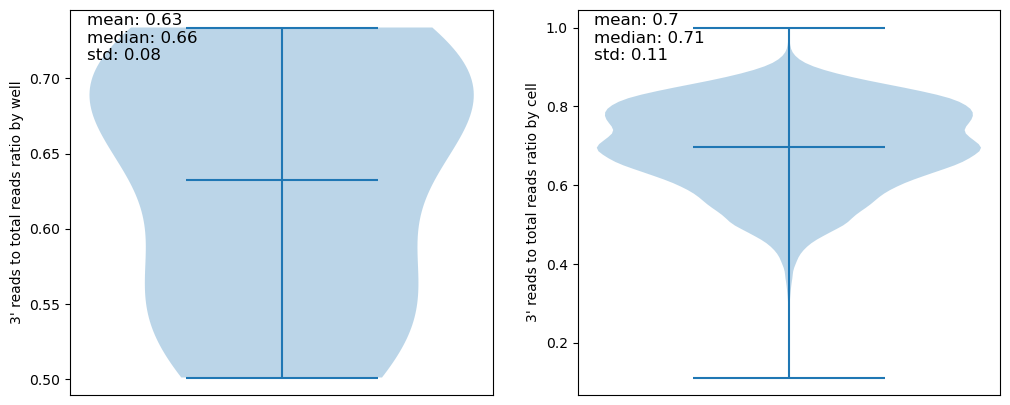

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

violinByWell(ax[0], wells_data.obs)
violinByCell(ax[1], parse_data.obs)

plt.show()

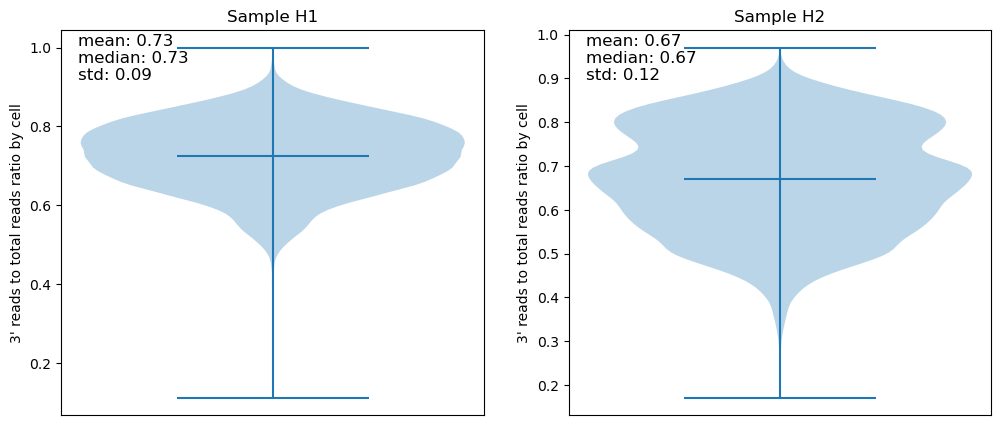

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ax, sample_name in zip(axs, sample_names):
    obs = parse_data.obs[parse_data.obs['sample']==sample_name]
    violinByCell(ax, obs)
    ax.set_title(f"Sample {sample_name}")

plt.show()

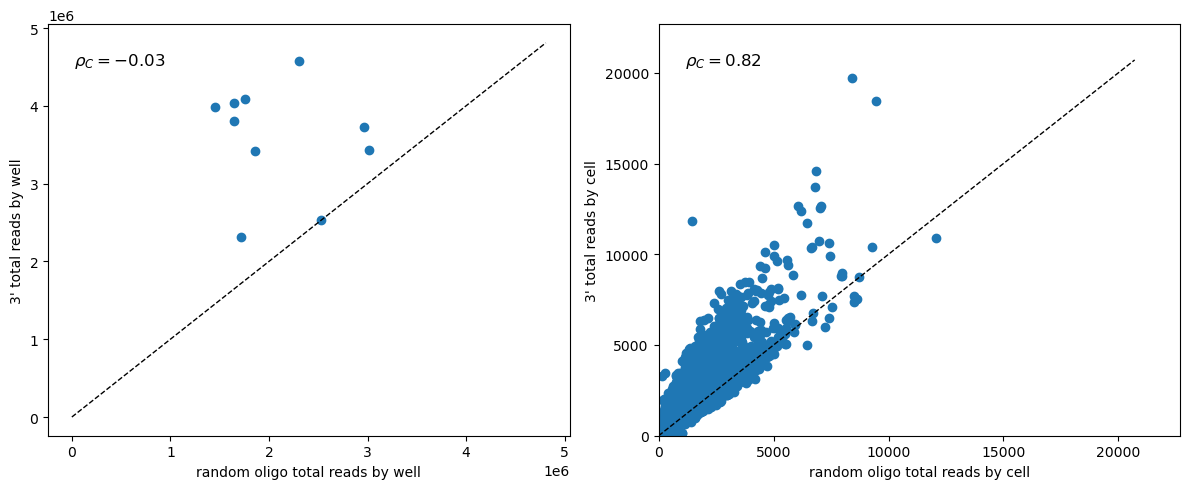

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plotByWell(ax[0], wells_data.obs)
plotByCell(ax[1], parse_data.obs)

plt.tight_layout()
plt.show()

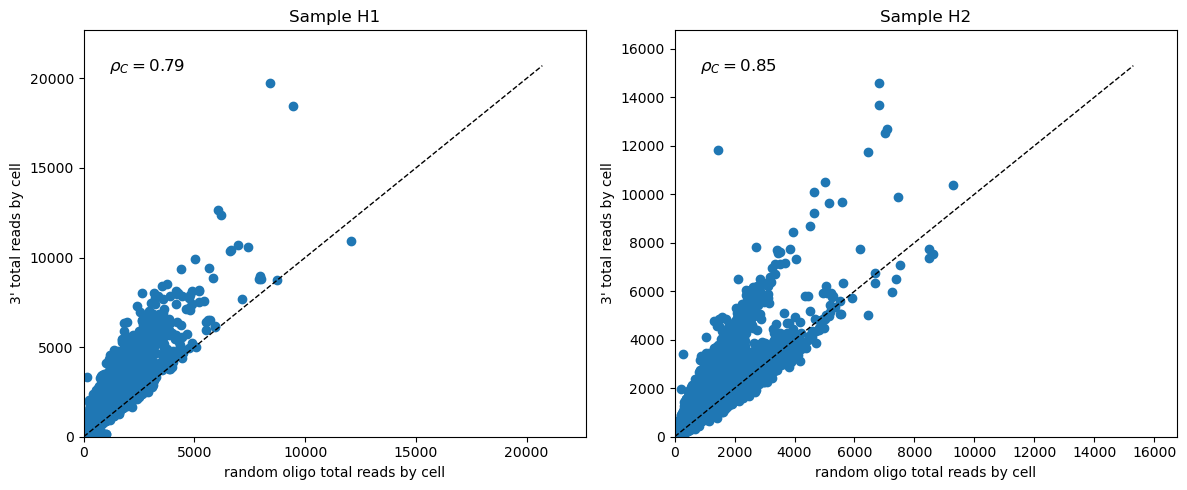

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ax, sample_name in zip(axs, sample_names):
    plotByCell(ax, parse_data.obs[parse_data.obs['sample']==sample_name])
    ax.set_title(f"Sample {sample_name}")

plt.tight_layout()
plt.show()

In [30]:
# filter based off of UMI threshold (specified by min_counts)
def refilter(raw_data, min_counts):
    data = raw_data.copy()
    sc.pp.filter_cells(data, min_counts=min_counts)
    data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
    data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    data.var['percent_counts'] = data.X.sum(axis=0).A1/data.X.sum() * 100
    
    return data

# Knee plot with threshold axes
def knee_plot(ax, raw_data, cutoff = 20):
    knee = np.sort((np.array(raw_data.X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]

    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")
    ax.set_title(raw_data.uns['title'] + " Knee Plot")

    print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold for {raw_data.uns['title']}")
    data = refilter(raw_data, knee[num_cells])
    
    return data

34,194 cells passed the 300 UMI threshold for Wells


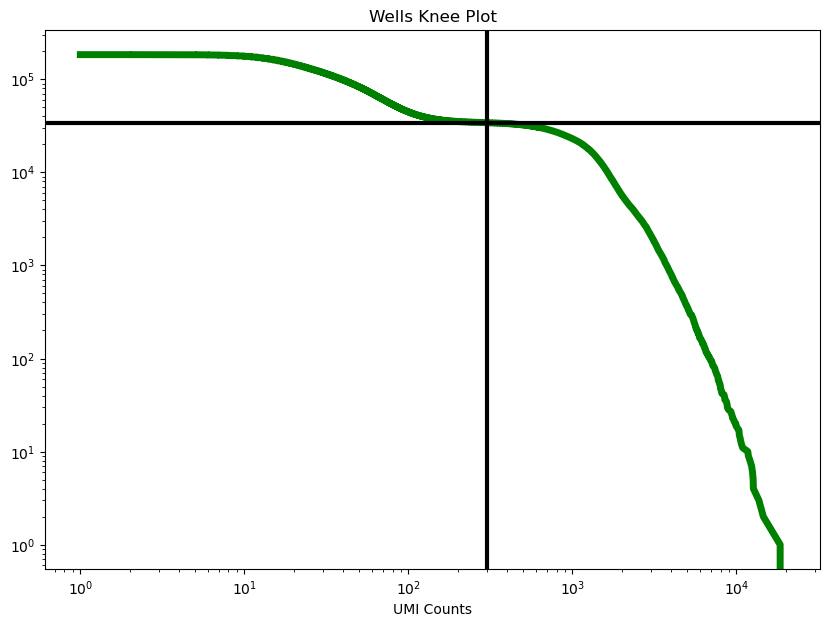

In [31]:
fig, ax = plt.subplots(figsize=(10, 7))

wells_filtered = knee_plot(ax, wells_data, cutoff = 300)
plt.show()

17,170 cells passed the 600 UMI threshold for Parse


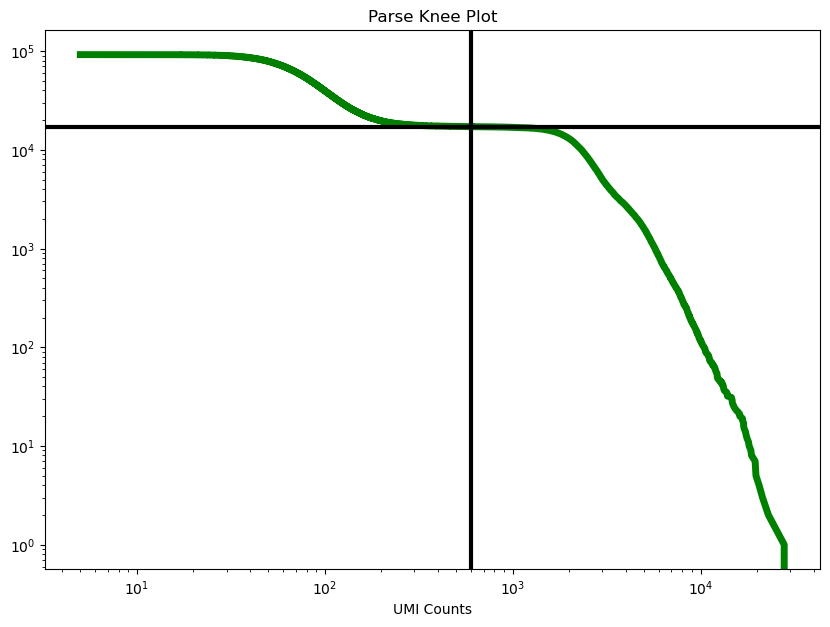

In [40]:
fig, ax = plt.subplots(figsize=(10, 7))

parse_filtered = knee_plot(ax, parse_data, cutoff = 600)
plt.show()

9,332 cells passed the 600 UMI threshold for Parse
7,837 cells passed the 600 UMI threshold for Parse


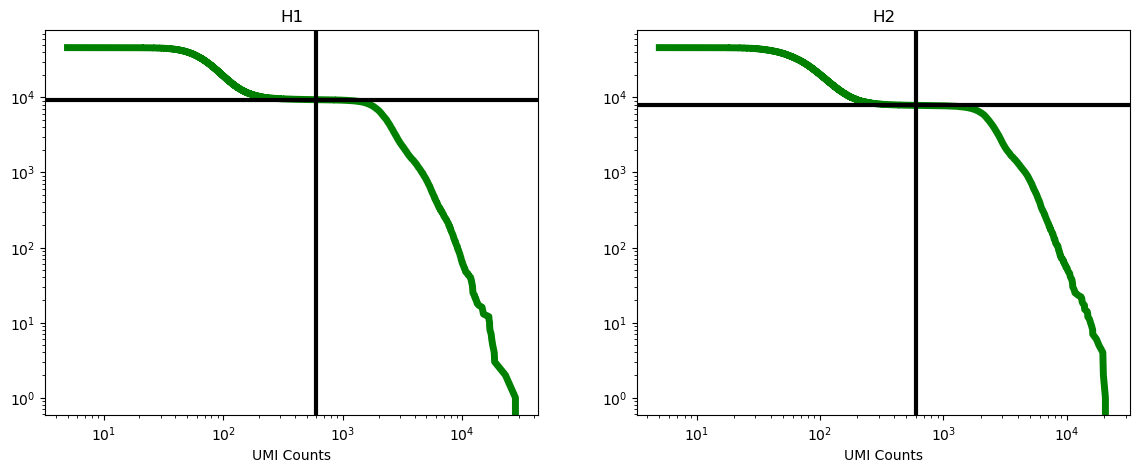

In [41]:
fig, axs = plt.subplots(1,2, figsize=(14, 5))

for ax, sample_name in zip(axs, sample_names):    
    sample_data = parse_data[(parse_data.obs['sample'] == sample_name).tolist(),:]
    knee_plot(ax, sample_data, cutoff = 600)
    ax.set_title(sample_name)

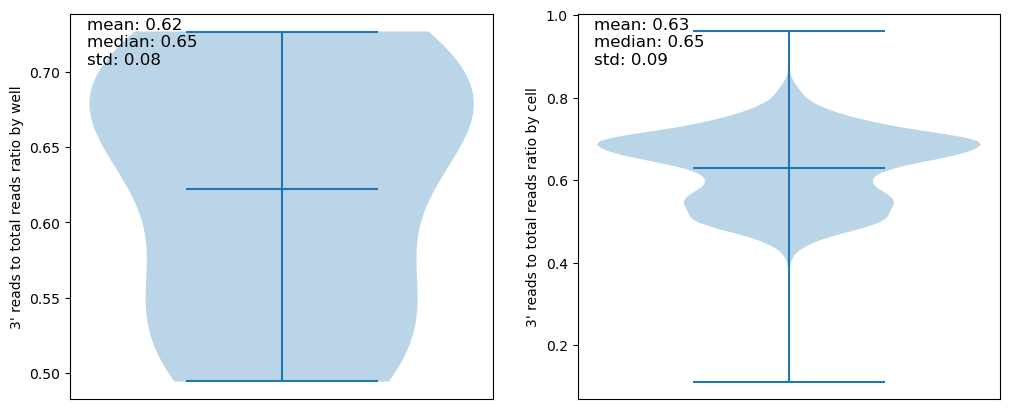

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

violinByWell(ax[0], wells_filtered.obs)
violinByCell(ax[1], parse_filtered.obs)

plt.show()

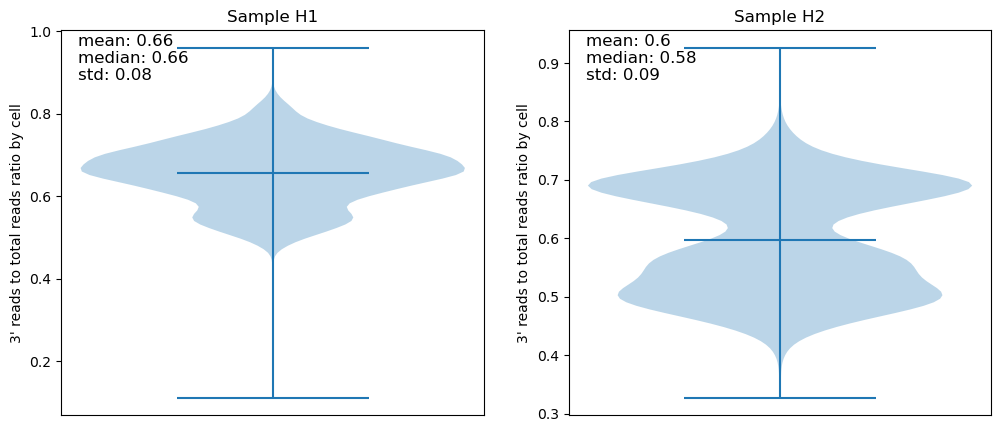

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ax, sample_name in zip(axs, sample_names):
    obs = parse_filtered.obs[parse_filtered.obs['sample']==sample_name]
    violinByCell(ax, obs)
    ax.set_title(f"Sample {sample_name}")

plt.show()

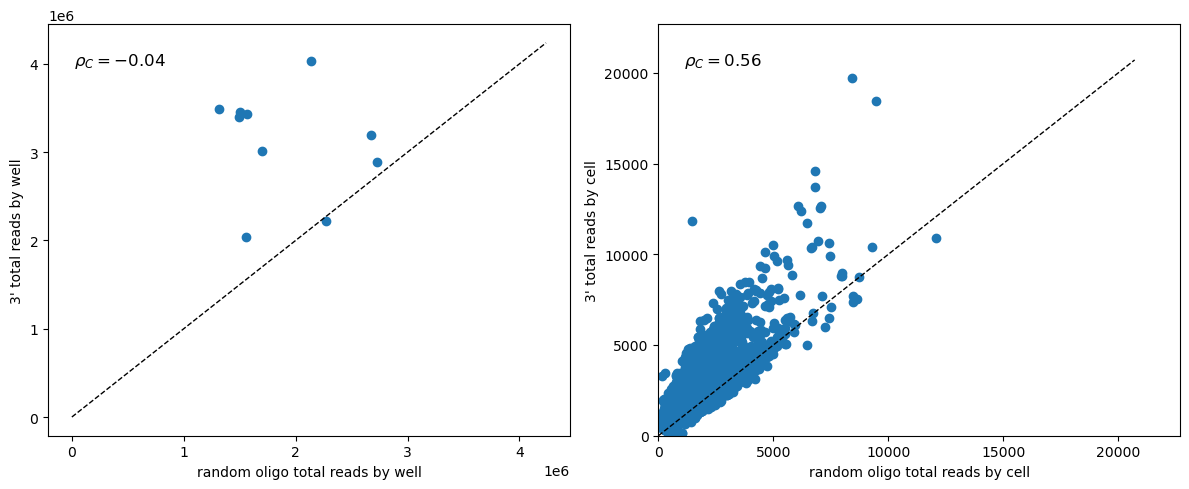

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plotByWell(ax[0], wells_filtered.obs)
plotByCell(ax[1], parse_filtered.obs)

plt.tight_layout()
plt.show()

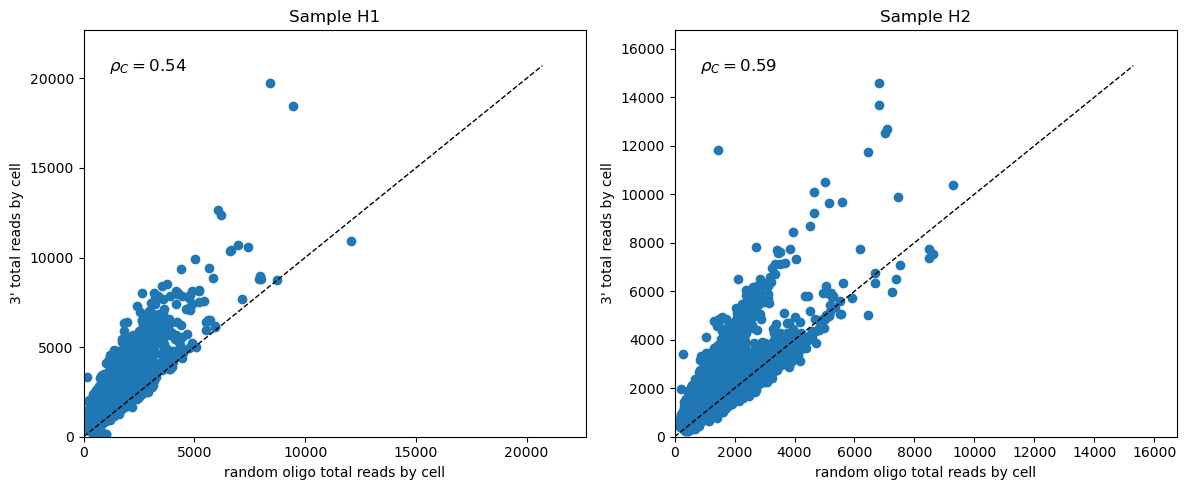

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ax, sample_name in zip(axs, sample_names):
    plotByCell(ax, parse_filtered.obs[parse_filtered.obs['sample']==sample_name])
    ax.set_title(f"Sample {sample_name}")

plt.tight_layout()
plt.show()